# Using NP4VTT: Klein-Spady estimator

In this notebook, we show how to use a Klein-Spady estimator to estimate the distribution of the Value of Travel Time (VTT) from the Norway data.

## Step 1: Load modules and data, and create arrays

We first import the NP4VTT modules for creating the arrays, the Klein-Spady, and Pandas to load the dataset:

In [10]:
import pandas as pd
import numpy as np
from py_np4vtt.data_format import StudyVar
from py_np4vtt.model_kspady import ModelKSpady, ConfigKSpady
from py_np4vtt.data_import import make_modelarrays, compute_descriptives


ModuleNotFoundError: No module named 'py_np4vtt.model_kspady'

NameError: name 'py_np4vtt' is not defined

Now we read the CSV file:

In [ ]:
df = pd.read_table('../data/Norway09_data_v5.txt')
df.head()

,RespID,Mode,TravTime,BaseCost,Gender,AgeClass,IncClass,TravTimeClass,Purpose,CardID,...,TimeL,TimeR,Chosen,Quadrant2,Purpose2,Mode2,Income2,ExclGroup,Exclude_CDF,CS
0,88,1,25,27,1,3,5,1,1,1,...,32,25,1,4,1,1,3,4,1,1
1,88,1,25,27,1,3,5,1,1,2,...,25,28,2,2,1,1,3,4,1,2
2,88,1,25,27,1,3,5,1,1,3,...,29,25,1,4,1,1,3,4,1,3
3,88,1,25,27,1,3,5,1,1,4,...,32,25,1,2,1,1,3,4,1,4
4,88,1,25,27,1,3,5,1,1,5,...,29,32,2,2,1,1,3,4,1,5


The dataset contains 22 variables. Each row is a binary choice task. We will use:

* `RespID`: ID of each respondent.
* `Chosen`: Chosen alternative.
* `CostL` and `CostR`: Travel cost of alternatives 1 and 2, respectively.
* `TimeL` and `TimeR`: Travel time of alternatives 1 and 2, respectively.

NP4VTT detects automatically the _slow-cheap_ and _fast-expensive_ alternative, for each choice situation. If NP4VTT finds violations to those two options (e.g., a fast-cheap) alternative, it will raise an error message.

Change currency of travel time to euros and change unit of travel time to hours

In [ ]:
# Convert to euros
NOK2euro_exchange_rate = 9
df[['CostL','CostR']] = df[['CostL','CostR']] .div(NOK2euro_exchange_rate)

# convert to hours
df[['TimeL','TimeR']] = df[['TimeL','TimeR']] .div(60)

Now we create a dictionary to map the required variables for NP4VTT with the variables of the dataset:

In [ ]:
columnarrays = {
    StudyVar.Id: 'RespID',
    StudyVar.ChosenAlt: 'Chosen',
    StudyVar.Cost1: 'CostL',
    StudyVar.Cost2: 'CostR',
    StudyVar.Time1: 'TimeL',
    StudyVar.Time2: 'TimeR',
}

And we create the required arrays:

In [ ]:
model_arrays = make_modelarrays(df, columnarrays)

The function `make_modelarrays` creates six elements used by NP4VTT to estimate/train a model:

* `BVTT`: Contains the Boundary VTT per choice situation, computed from costs and time.
* `Choice`: A matrix of dummy variables that are equal to one if the respondent choose the fast-expensive alternative on each choice situation.
* `Accepts`: Number of times a respondent chose the fast-expensive alternative.
* `ID`: Unique identifier of each respondent.
* `NP`: Number of respondents in the dataset.
* `T`: Number of choice situations per respondent.

## Step 2: Compute descriptives

The function `compute_descriptives` provides a small overview of the dataset characteristics:

In [ ]:
descriptives = compute_descriptives(model_arrays)
print(descriptives)

No. individuals: 5832
Sets per indiv.: 9

Number of non-traders:
Fast-exp. alt.: 144
Slow-cheap alt.: 808

BVTT statistics:
Mean chosen BVTT: 0.5370130170428368
Minimum of BVTT: 0.1
Maximum of BVTT: 17.03448275862069


## Step 3: Configure the Klein-Spady

The Klein-Spady requires the following parameters from the user:

* `minimum`: The minimum of the VTT grid.
* `maximum`: The maximum of the VTT grid.
* `supportPoints`: The number of support points.

The function `ConfigLocLogit` takes the configuration parameters of the Klein-Spady and creates an object that is used by the optimisation routine:

In [ ]:
config = ConfigKSpady(minimum=0, maximum=18, supportPoints=19)

Now, we create the Klein-Spady object that contains the configuration parameters and the data arrays. Then, we initialise the arguments:

In [ ]:
ks = ModelKSpady(config, model_arrays)
initialArgs = ks.setupInitialArgs()

## Step 4: Estimate a Klein-Spady estimator

Once the Klein-Spady object is initialised, the `run` method starts the optimisation process:

In [ ]:
p, vtt_grid = ks.run(initialArgs)

The estimated model returns the following information:

* `p:` The cumulative probability of each point of the VTT grid.
* `fval:` Value of the likelihood function in the optimum.
* `vtt_grid:` The VTT grid

The following lines present the estimated results:

In [ ]:
import numpy as np

# Create dataframe
results = pd.Series(p,name='Cum. Prob.',index=vtt_grid.astype(int))

print('Estimation results:\n')
# print('Final log-likelihood: ' + str(round(fval,2)))
print('\nEstimated Cumulative probability:')
print(results)

Estimation results:


Estimated Cumulative probability:
0     0.396671
1     0.486366
2     0.611280
3     0.742138
4     0.820064
5     0.860693
6     0.891506
7     0.911423
8     0.921852
9     0.925695
10    0.926800
11    0.934545
12    0.943984
13    0.943679
14    0.943879
15    0.954521
16    0.958239
17    0.949326
18    0.945791
Name: Cum. Prob., dtype: float64


## Step 5: Do plots

We create the ECDF of the VTT distribution. We use matplotlib for this:

(0.0, 20.0)

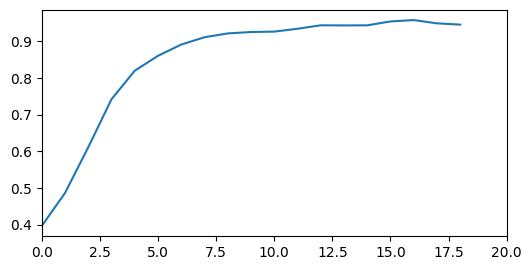

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,3), dpi=100)

ax.plot(vtt_grid,p)
plt.xlim([0, 20])

NameError: name 'vtt_grid' is not defined

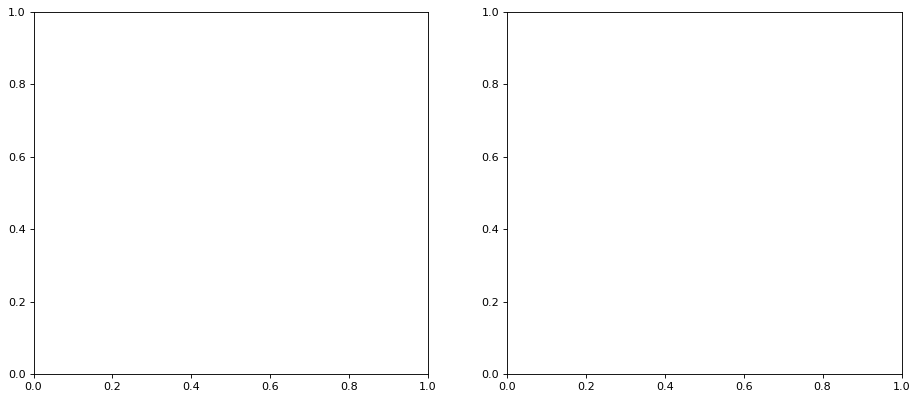

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,2,figsize=(14,6), dpi=80)

# Plot CDF
ax[0].plot(vtt_grid[1:],p,marker='o')
ax[0].set_xlim(0,80)
ax[0].set_ylim(0,1)
ax[0].set_xlabel('VTT [euro/hour]')
ax[0].set_ylabel('Cumulative probability')

# Plot histogram
# Obtain the midpoints from the vtt_grid
vtt_grid_mid = ((np.append(vtt_grid, 0) + np.append(0,vtt_grid)))/2
vtt_grid_mid = vtt_grid_mid[:-1]

# Obtain probabilities from the CDF plot
pp = (np.append(p, 0)-np.append(0,p))
pp = pp[:-1]
pp = pp + np.abs(np.min(pp))
pp = (np.divide(pp,np.sum(pp)))

# Construct data points
data_hist = []
for n in range(1,len(vtt_grid_mid)):
    dat = [vtt_grid_mid[n]]*np.round((pp[n-1]*descriptives.NP)).astype(int)
    data_hist = np.append(data_hist,dat)

# Plot histogram    
ax[1].set_xlim(0,80)
ax[1].set_xlabel('VTT [euro/hour]')
ax[1].set_ylabel('Count')
ax[1].hist(data_hist, bins = vtt_grid_mid)
plt.show()